_This notebook contains code and comments from Sections 6.3 and 6.4 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

## 6.3 XGBoost: A Framework for Newton Boosting
[XGboost](https://xgboost.readthedocs.io/en/latest/), or eXtreme Gradient Boosting is a popular open-source gradient boosting framework. It was originally developed by Tianqi Chen and gained widespread popularity when it won the Higgs Boson Kaggle Challenge in 2014. Like LightGBM, XGBoost is a highly-scalable tree boosting package that can be extended to work with millions of data points. XGBoost offers the following advantages:
* Parallelization and cache-aware optimization for highly efficient tree learning, to enable support for ver large data sets and lower memory usage (Section 6.3.1)
* Newton boosting with regularized learning objectives (Section 6.3.1)
* Support for a large number of loss functions for classification, regression and ranking as well as application-specific custom loss functions (Section 6.3.2);

### 6.3.2 Newton Boosting with XGBoost
See the documentation of XGBoost for [installation instructions](https://xgboost.readthedocs.io/en/latest/build.html); it can be installed quickly with pip or built from the source up. 

We kick off our explorations of XGBoost with the breast cancer data set, which we have used several times in the past as a benchmark data set.

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
X, y = load_breast_cancer(return_X_y=True)
Xtrn, Xtst, ytrn, ytst = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

Train a simple Newton boosting classifier using XGBoost

In [2]:
from xgboost import XGBClassifier
ens = XGBClassifier(n_estimators=20, max_depth=1, objective='binary:logistic', verbosity=0)
ens.fit(Xtrn, ytrn)

c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [3]:
from sklearn.metrics import accuracy_score
ypred = ens.predict(Xtst)
accuracy_score(ytst, ypred)

0.9649122807017544

In [4]:
import xgboost as xgb
trn = xgb.DMatrix(Xtrn, label=ytrn)
tst = xgb.DMatrix(Xtst, label=ytst)

params = {'max_depth': 1, 'objective':'binary:logistic'}
ens2 = xgb.train(params, trn, num_boost_round=20)

ypred_proba = ens2.predict(tst)
ypred = (ypred_proba >= 0.5).astype(int)
accuracy_score(ytst, ypred)

0.9649122807017544

---
## 6.4 XGBoost in Practice

### 6.4.1 Learning Rate
Like LightGBM, XGBoost also plays nicely with scikit-learn, and we can combine the relevant functionalities from both packages to perform effective model learning.

In the experiment below, we repeat the experiment from the previous chapter to combine ``scikit-learn``'s [``StratifiedKFold``](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) class to split the training data into several folds of training and validation sets. ``StratifiedKFold`` ensures that we preserve class distributions, that is, the fractions of different classes across the folds.

**Listing 6.5**: Cross Validation with XGBoost and scikit-learn

In [5]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

# Initialize choices of learning rates, number of cross-validation folds
n_folds = 10
learning_rates = np.concatenate([np.linspace(0.02, 0.1, num=5),
                                 np.linspace(0.2, 1.8, num=9)])
n_learning_rate_steps = len(learning_rates)
print(learning_rates)

# Split the data into training and validation folds
splitter = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize some structures to save training and validation errors
trn_err = np.zeros((n_learning_rate_steps, n_folds))
val_err = np.zeros((n_learning_rate_steps, n_folds))

# Train LightGBM classifier for different learning rates and plot the results
for i, rate in enumerate(learning_rates):
    for j, (trn, val) in enumerate(splitter.split(X, y)):
        gbm = XGBClassifier(n_estimators=10, max_depth=1, learning_rate=rate, verbosity=0, use_label_encoder=False)
        gbm.fit(X[trn, :], y[trn])

        trn_err[i, j] = (1 - accuracy_score(y[trn], gbm.predict(X[trn, :]))) * 100
        val_err[i, j] = (1 - accuracy_score(y[val], gbm.predict(X[val, :]))) * 100

        
trn_err = np.mean(trn_err, axis=1)
val_err = np.mean(val_err, axis=1)

[0.02 0.04 0.06 0.08 0.1  0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8 ]


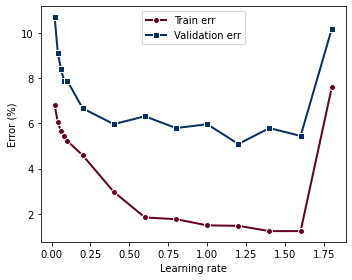

In [6]:
import matplotlib.pyplot as plt
from visualization import get_colors
cm = get_colors(colormap='RdBu', n_colors=2)

%matplotlib inline
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))

ax.plot(learning_rates, trn_err, marker='o', c=cm[0], markeredgecolor='w', linewidth=2)
ax.plot(learning_rates, val_err, marker='s', c=cm[1], markeredgecolor='w', linewidth=2)
ax.legend(['Train err', 'Validation err'])
ax.set_xlabel('Learning rate')
ax.set_ylabel('Error (%)')

fig.tight_layout()
pngFile = './figures/CH06_F14_Kunapuli.png'
plt.savefig(pngFile, dpi=300, pad_inches=0)

**Listing 6.6**: Cross Validation with XGBoost

In [7]:
import xgboost as xgb

# Convert the training and test data into XGBoost.DMatrix format
trn = xgb.DMatrix(Xtrn, label=ytrn)
tst = xgb.DMatrix(Xtst, label=ytst)

params = {'learning_rate': 0.25, 'max_depth': 2, 'objective': 'binary:logistic'}
cv_results = xgb.cv(params, trn, num_boost_round=60, nfold=10, metrics={'error'}, seed=42)

In [8]:
cv_results.head()

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.052257,0.013810,0.085700,0.031741
1,0.042248,0.004104,0.085749,0.036141
2,0.032970,0.005720,0.065990,0.034372
3,0.032482,0.004791,0.065990,0.034187
4,0.030523,0.004249,0.063865,0.035097


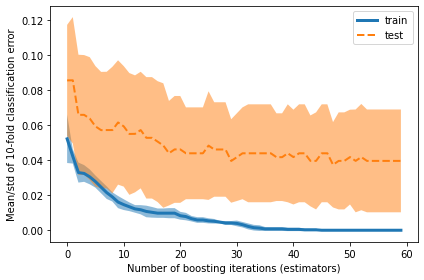

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n_estimators = 60
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
m = cv_results['train-error-mean']
s = cv_results['train-error-std']
ax.fill_between(range(n_estimators), m + s, m - s, alpha=0.5)
ax.plot(range(n_estimators), m, linewidth=3)

m = cv_results['test-error-mean']
s = cv_results['test-error-std']
ax.fill_between(range(n_estimators), m + s, m - s, alpha=0.5)
ax.plot(range(n_estimators), m, linestyle='--', linewidth=2)

ax.set_xlabel('Number of boosting iterations (estimators)')
ax.set_ylabel('Mean/std of 10-fold classification error');
ax.legend(['train', 'test'])

fig.tight_layout()
pngFile = './figures/CH06_F15_Kunapuli.png'
plt.savefig(pngFile, dpi=300, pad_inches=0)

### 6.4.2 Early Stopping
Early stopping with ``XGBoost`` works pretty similarly to LightGBM, where we specify a value for the parameter ``early_stopping_rounds``. As long as the overall score (say accuracy) improves over the last ``early_stopping_rounds``, ``XGBoost`` will continue to train. However, when the score does not improve after ``early_stopping_rounds``, ``XGBoost`` stops.

As with ``LightGBM``, ``XGBoost`` requires a validation set

**Listing 6.7**: Early Stopping with XGBoost 

In [10]:
# Create a single split of training and validation sets
Xtrn, Xval, ytrn, yval = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
ens = XGBClassifier(n_estimators=50, max_depth=2, objective='binary:logistic')
ens.fit(Xtrn, ytrn, early_stopping_rounds=5, eval_set=[(Xval, yval)], eval_metric='auc')

[0]	validation_0-auc:0.95480
[1]	validation_0-auc:0.96725
[2]	validation_0-auc:0.96757
[3]	validation_0-auc:0.99017
[4]	validation_0-auc:0.99099
[5]	validation_0-auc:0.99181
[6]	validation_0-auc:0.99410
[7]	validation_0-auc:0.99640
[8]	validation_0-auc:0.99476
[9]	validation_0-auc:0.99148
[10]	validation_0-auc:0.99050
[11]	validation_0-auc:0.99050


c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)